# Chapter 8 – Dimensionality Reduction
Curse of Dimensionality : 각 instance의 feature들에 의해 수가 많아져 학습이 느려지고 solution을 찾기 어려워짐 <br>
현실의 문제에서는 다루기 어려운 문제를 다루기 쉽게 바꾸어 feature를 상당히 줄일 수 있다. <br>
Example) MINST 이미지의 가장자리 픽셀은 거의 항상 하얀편이므로 이 픽셀부분을 drop하여 feature를 줄인다. 


**Reducing Dimensionality** 특징<br>
Reducing Dimensionality 는 정보를 약간 잃기 때문에 training 속도가 빨라지더라도 수행능력이 다소 안좋을 수 있다. <br>
그러므로 처음에는 original 데이터로 훈련시켜보고 너무 느릴경우에 차원감소를 고려한다. <br>
하지만 가끔 차원감소를 통해 noise와 불필요한 detail을 제거하여 성능이 더 좋아지는 경우도 있다. 

Dimensionality Reduction은 data visualization에 사용해도 좋다. <br>
차원을 줄이면 고차원(high-dimensional)학습세트를 그래프에 표시할 수 있고 종종 중요한 clusters등의 패턴을 감지하는데 효과적이다.


# The Curse of Dimensionality

    고차원의 공간에서는 많은 요소가 있기 때문에 2-3차원에서의 확률과 차이가 난다. 
    2차원에서 두 점의 거리는 평균적으로 0.52정도라 하면 1,000,000차원의 하이퍼큐브에서는 408.25정도이다. 직관적으로 떠올리기 어렵다.
    고차원의 데이터셋은 그 거리가 점점 넓어져 두 점이 매우 드물게(넓찍이) 위치하는 위험성이 있다. (Training set는 instance 끼리 서로 멀어지려고 한다.)
    이는 고차원일수록 새로운 instance가 다른 instance들과 멀리 떨어지려고 하고 그 의존도가 낮아진다는 것을 의미한다. 
    즉, Training set가 더 차원이 클 수록 overfitting의 위험도 커진다. 

    충분하게 Training data set의 크기를 증가하여 차원문제를 해결할 수 있지만 차원의 수에 따라 Training instance의 수는 기하급수적으로 증가한다. 
    

# Main Approaches for Dimensionality Reduction
Two main Approaches to Reducing Dimensionality
### 1. Projection

    training instance는 모든 차원에 골고루 균등하게 퍼져있지 않는다. 
    많은 feature들은 대부분 상수이지만 다른것들은 매우 연관성이 높다. 
    모든 training instance는 고차원 공간의 저차원적인 subspace에 놓이게 된다. 
<img src='8-1.PNG'>
    모든 tarining instance들이 평면에 가깝게 놓여있다. 이 평면을 High-dimensional(3D) 공간의 **lower-dimensional(2D) subspace**라 한다.
<img src='8-2.PNG'>   
    이 평면으로 모든 training instance들을 수직 투영 시키면 새로운 2D 데이터셋을 확보할 수 있다. 
<img src='8-3.PNG'>   
    하지만 이러한 projection이 차원감소에 항상 효과적인 것은 아니다. <br>
    Swiss roll dataset 처럼 많은 경우에 subspace가 꼬여있거나 돌아가있을 수 있다.<br>
    이런 경우에는 projecting의 방법을 사용하면 제대로 unrolling을 할 수 없다. (한계)

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [51]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Projection methods
Build 3D dataset:

In [52]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

## PCA using SVD decomposition

Note: the `svd()` function returns `U`, `s` and `Vt`, where `Vt` is equal to $\mathbf{V}^T$, the transpose of the matrix $\mathbf{V}$. Earlier versions of the book mistakenly said that it returned `V` instead of `Vt`. Also, Equation 8-1 should actually contain $\mathbf{V}$ instead of $\mathbf{V}^T$, like this:

Training Set Matrix X를 분해하여 U, s, V의 세 행렬로 나타낸다. 이때 $V^t$는 우리가 찾는 모든 PC를 포함한다.

$
\mathbf{V^t} =
\begin{pmatrix}
  \mid & \mid & & \mid \\
  \mathbf{c_1} & \mathbf{c_2} & \cdots & \mathbf{c_n} \\
  \mid & \mid & & \mid
\end{pmatrix}
$

In [53]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [54]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [55]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

In [56]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [57]:
X2D_using_svd = X2D

## PCA using Scikit-Learn

With Scikit-Learn, PCA is really trivial. It even takes care of mean centering for you:

In [58]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [59]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [60]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

Notice that running PCA multiple times on slightly different datasets may result in different results. In general the only difference is that some axes may be flipped. In this example, PCA using Scikit-Learn gives the same projection as the one given by the SVD approach, except both axes are flipped:

In [61]:
np.allclose(X2D, -X2D_using_svd)

True

Recover the 3D points projected on the plane (PCA 2D subspace).

In [62]:
X3D_inv = pca.inverse_transform(X2D)

Of course, there was some loss of information during the projection step, so the recovered 3D points are not exactly equal to the original 3D points:

In [63]:
np.allclose(X3D_inv, X)

False

We can compute the reconstruction error:

In [64]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.010170337792848549

The inverse transform in the SVD approach looks like this:

In [65]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

The reconstructions from both methods are not identical because Scikit-Learn's `PCA` class automatically takes care of reversing the mean centering, but if we subtract the mean, we get the same reconstruction:

In [66]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

The `PCA` object gives access to the principal components that it computed:

In [67]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

Compare to the first two principal components computed using the SVD method:

In [68]:
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

Notice how the axes are flipped.

Now let's look at the explained variance ratio:

In [69]:
pca.explained_variance_ratio_

array([ 0.84248607,  0.14631839])

The first dimension explains 84.2% of the variance, while the second explains 14.6%.

By projecting down to 2D, we lost about 1.1% of the variance:

In [70]:
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

Here is how to compute the explained variance ratio using the SVD approach (recall that `s` is the diagonal of the matrix `S`):

In [71]:
np.square(s) / np.square(s).sum()

array([ 0.84248607,  0.14631839,  0.01119554])

Next, let's generate some nice figures! :)

Utility class to draw 3D arrows (copied from http://stackoverflow.com/questions/11140163)

In [72]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

Express the plane as a function of x and y.

In [73]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

Plot the 3D dataset, the plane and the projections on that plane.

Saving figure dataset_3d_plot


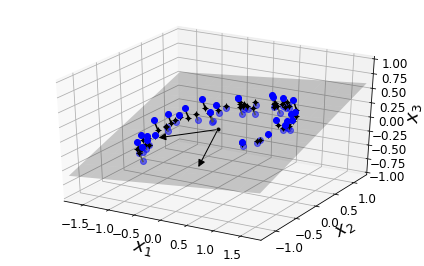

In [74]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("dataset_3d_plot")
plt.show()

Saving figure dataset_2d_plot


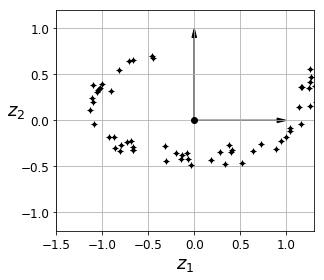

In [75]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)
save_fig("dataset_2d_plot")

## 2. Manifold Learning
    Swiss roll은 2D Manifold의 예이다. 
    2D manifold는 고차원의 공간에서 휘거나 구부려질 수 있는 2D shape을 말한다. 
    Manifold Learning이라는 차원 감소 알고리즘은 보통 training instance가 놓여있는 manifold를 모델링하는 방법으로 접근한다. 
    현실의 데이터셋은 매우 저차원의 mnifold와 가깝게 놓여있는데 이를 manifold assumption 나 mnifold hypothesis 라고 한다. 
    
    Manifold 가정은 저 차원 공간의 manifold로 표현되면 더 간단해 진다는 의미를 내포하지만 항상 그런것은아니다. 
    즉 Training Set 모델을 train 해보지 않고 차원을 낮추면 training의 속도는 빨라지지만 항상 더 좋은 결과만 나타나는 것은 아니다. 

In [76]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

Saving figure swiss_roll_plot


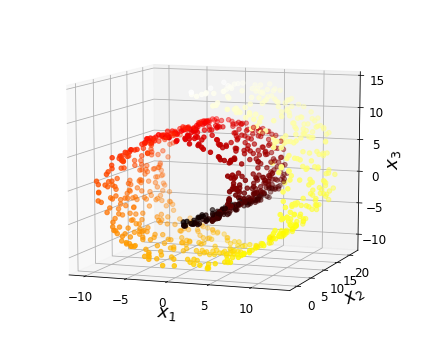

In [77]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("swiss_roll_plot")
plt.show()

Saving figure squished_swiss_roll_plot


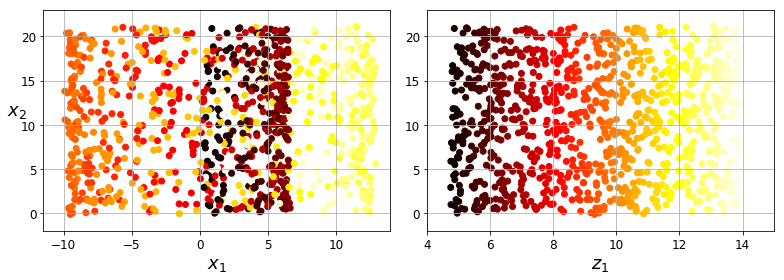

In [78]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

save_fig("squished_swiss_roll_plot")
plt.show()

Saving figure manifold_decision_boundary_plot1


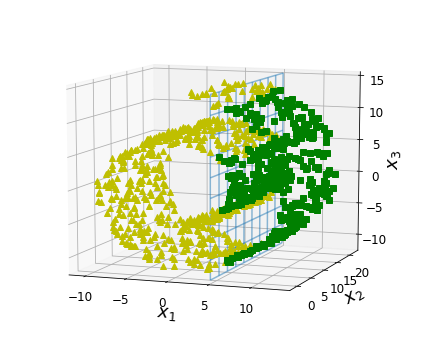

Saving figure manifold_decision_boundary_plot2


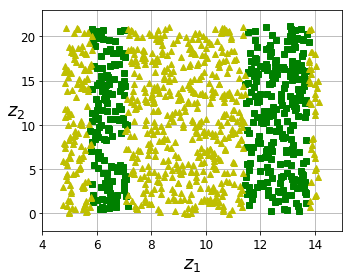

Saving figure manifold_decision_boundary_plot3


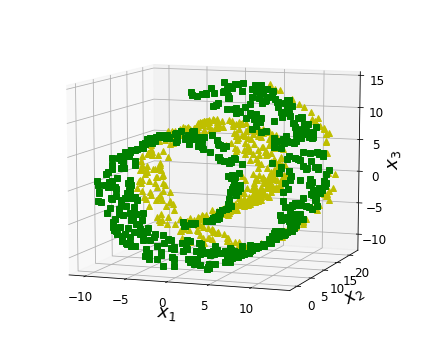

Saving figure manifold_decision_boundary_plot4


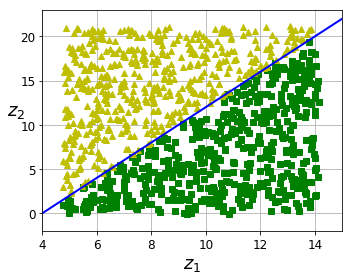

In [79]:
from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("manifold_decision_boundary_plot1")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

save_fig("manifold_decision_boundary_plot2")
plt.show()

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("manifold_decision_boundary_plot3")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

save_fig("manifold_decision_boundary_plot4")
plt.show()

## 3. PCA
    Principal Component Analysis(PCA) 는 가장 인기있는 Dimensionaity Reduction Algorithm이다. 
    첫째로 데이터에 가깝게 놓여있는 hyperplane을 확인하고 데이터를 그 평면으로 project 한다. 

### Preserving the Variance 
##### 적절한 hyperplane 설정하기
- hyperplane은 기존 차원보다 한 차원 낮은 초평면을 의미한다. (예, 3D 평면의 초평면은 2D 평면)
- 적절한 hyperplane의 예로 2차원 평면의 세 hyperplane(직선)에 대해 각각 데이터를 projection 하여 variance의 양이 가장큰 것을 선택한다. (가장 정보를 잘 보존했다는 뜻)



Saving figure pca_best_projection


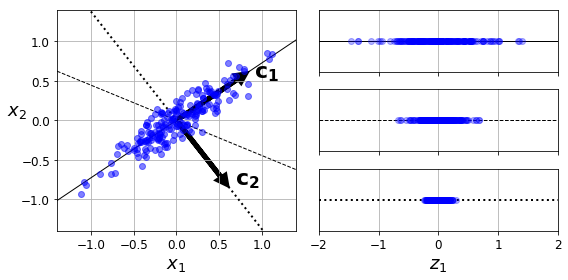

In [30]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

save_fig("pca_best_projection")
plt.show()

##### Principal Components
- 가장 큰 variance를 가지는 축을 설정한 뒤 설정하는 두번째 축은 첫번째 축의 직교선이다. 
- 차원이 높아질 수록 이러한 축이 증가할 것이다. 
- $i^{(th)}$ principal component(PC)는 $i^{(th)}$ 축을 정의한다.  
- 이러한 PC를 찾는 기술은 Sinual Value Decomposition(SVD)를 이용한다.        

##### Projecting Down to d Dimensions
- 모든 PC를 찾은뒤 차원을 첫번째 d principal component에 의한 hyperplane으로 투영하여 d dimensions로 낮춘다. 0
- 예를 들어 3D dataset을 2D plane으로 투영하여 dataset's variance가 가장 큰 부분을 보존하여 3D 일때와 가장 비슷하게 보이도록 한다. 
- Training set를 hyperplane으로 투영하므로써 training set 행렬 X와 첫번째 d principal component를 포함하는 $W_b$의 내적 계산이 쉬워진다.
- $X_{d-proj}=X\cdot W_d$

##### Explained Variance Ratio
- 각각의 Principal component의 explanined variance ratio 정보도 매우 유용하다. ("explained_variance_ratio_"로 사용가능) 
- 각 Principal component 축에 위치하는 dataset's variance의 비율을 나타낸다.
<img src='8-1.PNG'>
- 예를 들어 위 그림의 첫번째 두 components에 대한 explained variance ratio는 첫번째 축에 놓일 확률은 84%, 두번째 축은 14%로 표현된다.

In [18]:
pca.explained_variance_ratio_

array([ 0.84248607,  0.14631839])

##### Choosing the Right Number of Dimensions
- 차원을 얼마나 줄일지 마음대로 정하는 것이 아니고 일반적으로 충분히 큰 분산비율(예, 95%)을 가질 때까지 계속한다. 
- 시각화를 위한 차원 감소는 2-3차원까지 해도 된다.
- 감소할 구체적인 수를 정하지 않더라도 0~1.0 사이의 값을 지정하여 원하는 분산의 비율을 설정할 수 있다. 
- 또다른 방법은 explained variance와 차원사이의 그래프를 그리는 것이다. dimension은 그래프의 elbow부분으로 줄이더라도 explained variance를  크게 잃지는 않는다.


# PCA for MNIST compression

    차원 감소를 한뒤 training set는 훨씬 공간을 덜 차지한다. 
    EX. MNIST 데이터에 variance를 95%로 유지하며 PCA를 적용하면, 
    각각의 instance가 기존의 784개의 feature에서 150개로 줄어든 것으로 볼수 있다. 
    대부분의 variance는 유지되고 data set도 기존 사이즈의 20% 이하이다. 
    이러한 합리적인 압축율로 분류 등의 수행시간은 매우 빨라지는 것을 알 수 있다. 
    PCA 투영의 역변환을 적용하여 축소 된 데이터 세트를 다시 784 차원으로 압축을 풀 수도 있다. 
    기존의 데이터를 주진 않지만 기존의 데이터와 비슷하다. 
    
    이러한 inverse transformation 식은 아래와 같다
$$X_{recovered} = X_{d-proj}\cdot {W_d}^T$$

In [19]:
from six.moves import urllib
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [20]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [21]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [22]:
d

154

In [23]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [24]:
pca.n_components_

154

In [25]:
np.sum(pca.explained_variance_ratio_)

0.95044630302001876

In [26]:
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [27]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

Saving figure mnist_compression_plot


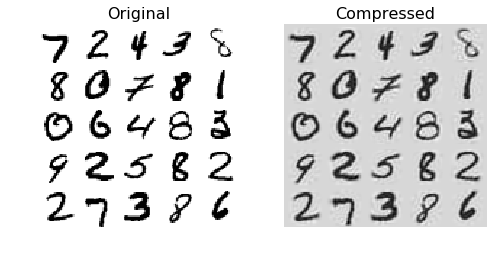

In [28]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

save_fig("mnist_compression_plot")

In [29]:
X_reduced_pca = X_reduced

# Incremental PCA


    PCA의 이전 구현에서의 한 가지 문제점은 SVD 알고리즘을 실행하기 위해 전체 훈련 세트가 메모리에 적합하도록 요구된다는 점이다. 
    Incremental PCA (IPCA)는 training set를 mini batch로 분할하여 한번에 한 batch씩 IPCA에 할당한다.
    training set가 클때 효과적이다. 


MNIST 데이터 세트를 100개의 Mini-batch로 나눈작업

In [30]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="") # not shown in the book
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [36]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

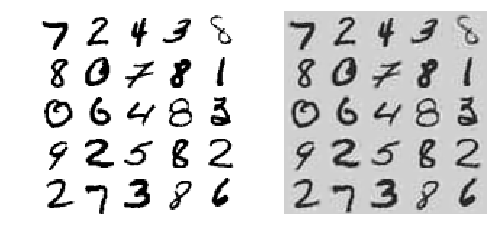

In [32]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

In [33]:
X_reduced_inc_pca = X_reduced

Let's compare the results of transforming MNIST using regular PCA and incremental PCA. First, the means are equal: 

In [34]:
np.allclose(pca.mean_, inc_pca.mean_)

True

But the results are not exactly identical. Incremental PCA gives a very good approximate solution, but it's not perfect:

In [35]:
np.allclose(X_reduced_pca, X_reduced_inc_pca)

False

### Using `memmap()`

큰 array에서 필요한 데이터만 불러와서 용량의 크기가 작은편. 

Let's create the `memmap()` structure and copy the MNIST data into it. This would typically be done by a first program:

In [37]:
filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

Now deleting the `memmap()` object will trigger its Python finalizer, which ensures that the data is saved to disk.

In [38]:
del X_mm

Next, another program would load the data and use it for training:

In [39]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, copy=True, n_components=154, whiten=False)

In [40]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

## Time complexity

## randomized PCA
Let's time regular PCA against Incremental PCA and Randomized PCA, for various number of principal components:<br>
첫번째 d principal components의 근사치를 빠르게 찾아주는 알고리즘

In [41]:
import time

for n_components in (2, 10, 154):
    print("n_components =", n_components)
    regular_pca = PCA(n_components=n_components)
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver="randomized")

    for pca in (regular_pca, inc_pca, rnd_pca):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print("    {}: {:.1f} seconds".format(pca.__class__.__name__, t2 - t1))

n_components = 2
    PCA: 2.1 seconds
    IncrementalPCA: 20.4 seconds
    PCA: 2.2 seconds
n_components = 10
    PCA: 2.4 seconds
    IncrementalPCA: 21.5 seconds
    PCA: 2.6 seconds
n_components = 154
    PCA: 4.9 seconds
    IncrementalPCA: 27.9 seconds
    PCA: 4.8 seconds


Now let's compare PCA and Randomized PCA for datasets of different sizes (number of instances):

Text(0.5,1,'PCA and Randomized PCA time complexity ')

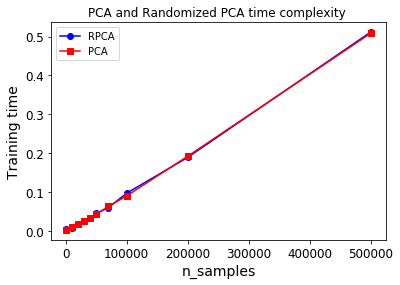

In [42]:
times_rpca = []
times_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    pca = PCA(n_components = 2, svd_solver="randomized", random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

And now let's compare their performance on datasets of 2,000 instances with various numbers of features:

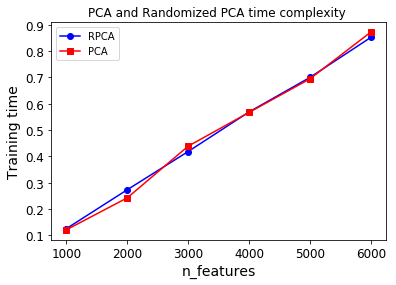

In [54]:
times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components = 2, random_state=42, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_features")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

# 4. Kernel PCA

    Kernel : 인스턴스를 고차원 공간으로 암시적 매핑을 통해 비선형 분류 및 회귀를 가능하게하는 수학기술이다. 
    
    Kenel PCA 방법은 인스턴스의 cluster를 투영후에도 잘 보존하고 뒤틀린 manifold 에 가깝에 놓여있는 데이터들도 펼치기에도 좋다. 

In [80]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [81]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

Saving figure kernel_pca_plot


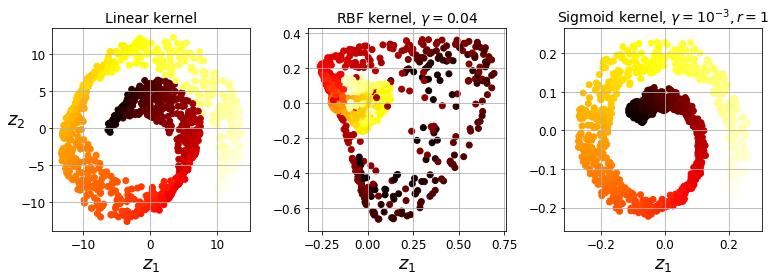

In [82]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("kernel_pca_plot")
plt.show()

위의 그림은 swiss roll을 각각의 Kernel을 사용해 2D dimension으로 감소시킨 모습이다. 

Saving figure preimage_plot


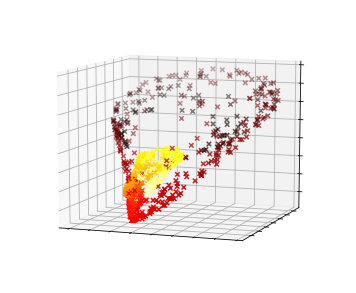

In [58]:
plt.figure(figsize=(6, 5))

X_inverse = pca.inverse_transform(X_reduced_rbf)

ax = plt.subplot(111, projection='3d')
ax.view_init(10, -70)
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], c=t, cmap=plt.cm.hot, marker="x")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

save_fig("preimage_plot", tight_layout=False)
plt.show()

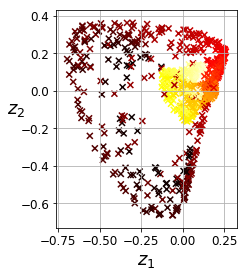

In [59]:
X_reduced = rbf_pca.fit_transform(X)

plt.figure(figsize=(11, 4))
plt.subplot(132)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot, marker="x")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

## Selecting Kernel and Tuning Hyperparameters

     kPCA는 unsupervised learning 알고리즘이며 가장 좋은 kernel과 hyperparameter의 명확한 측정 방법이 없다. 
     그러나 차원감소는 종종 supervised learning의 준비단계로 사용되기 때문에 grid search를 통해 kernel과 hyperparameter를 선택할 수 있다. 
     
     1. kPCA를 사용하여 차원을 2차원으로 감소시키고 Logistic Regression을 적용하여 분류한다. 
     2. Grid SearchCV를 사용하여 가장 좋은 kernel과 gamma 값을 찾는다. (분류에 정확도가 가장 높은 것을 근거로)

In [83]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression())
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('kpca', KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=False, gamma=None, kernel='linear',
     kernel_params=None, max_iter=None, n_components=2, n_jobs=1,
     random_state=None, remove_zero_eig=False, tol=0)), ('log_reg', LogisticRegre...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'kpca__gamma': array([ 0.03   ,  0.03222,  0.03444,  0.03667,  0.03889,  0.04111,
        0.04333,  0.04556,  0.04778,  0.05   ]), 'kpca__kernel': ['rbf', 'sigmoid']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

**Best kernel과 Hyperparameter값은 "best_params_"로 확인**

In [61]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


In [62]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [63]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.786308795766139

# 5. LLE
    Locally Linear Embedding (LLE) 
    - 강력한 non-linear dimensionality reduction(NLDR) 기법
    - 이전의 Projection에 의존하던 알고리즘과 다른 Manifold Learning 기술
    - 각 training 인스턴스가 가까운 이웃(neighbor)과 얼마나 선형적으로 관련있는지 측정하고 
    - 이러한 로컬 관계가 가장 잘 유지되는 저차원의 training set 표현을 찾는다. (-> ??)
    - 이런한 방법은 특히 노이즈가 많지 않을 경우에 꼬여있는 manifold를 풀기에 좋다.
   

 **Example** <br>
    Scikit-Learn의 "LocallyLinearEmbedding" 클래스를 사용하여 Swiss roll을 풀 수 있다. 

In [84]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [85]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

Saving figure lle_unrolling_plot


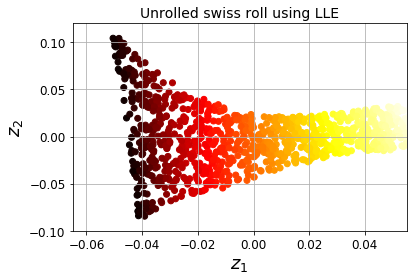

In [86]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

save_fig("lle_unrolling_plot")
plt.show()

    위의 결과처럼 Swiss roll이 완벽히 풀어졌고 instance들 사이의 거리가 Locally(국부적)하게 유지된다.
    
    그러나 instance들 사이의 거리는 왼쪽이 오른쪽보다 더 늘어지게 나열된 것처럼 큰 규모로 유지되지 않는다. 
    
    그래도 manifold를 모델링하기에는 좋은 기법

### LEE Work
1) 각 인스턴스 $x^{(i)}$에 대해 k개의 가장 가까운 이웃들을 식별한다. (예제에서는 k=10으로 사용)<br>
2) 그런 다음 그 이웃들의 선형 함수로 $x^{(i)}$를 재구성한다. <br>
3) 구체적으로 $x^{(i)}$와 $\sum_{j=1}^m {w_{i,j}x^{(i)}}$ 사이 거리의 제곱과 같은 가중치 $w_{i,j}$의 가능한 작은 값을 찾는다. <br>
4) 이때 $x^{(i)}$의 가까운 이웃 k가 아닌경우 $w_{i,j}$는 0이다.  <br>

**1.**
따라서 LLE의 첫 번째 단계는 식 8-4에 설명 된 문제의 제약된 최적화 (W : 모든 가중치w를 포함하는 가중치 행렬)<br>
두번째 제약은 단순하게 학습 인스턴스 x에 대한 가중치를 정규화한다.<br>
그다음 가중치 행렬(W)은 학습 인스턴스 사이의 로컬 선형관계를 인코딩한다. <br>

**2.**
학습 인스턴스를 로컬 관계를 최대한 유지하면서 d-dimensional 공간으로 매핑한다.<br>
그다음  $x^{(i)}$의 매핑된 이미지를  $z^{(i)}$라 할때 $z^{(i)}$와 $\sum_{j=1}^m {w_{i,j}z^{(i)}}$ 사이 거리의 제곱을 가능한 작게 한다. 
(비제약된 최적화를 이끄는 것)





# 6. Other Dimensionality Reduction Techniques 

### 1.MDS : 
각 인스턴스 사이의 거리를 유지하면서 차원을 감소한다.
### 2. Isomap : 
각 인스턴스의 가장 가까운 이웃을 연결하여 그래프로 나타낸다. (geodesic distance?를 최대한 유지하면서)
### 3. t-SNE : 
비슷한 인스턴스는 가까이 유지하고 비슷하지 않을 경우에는 멀리 간격을 두면서 차원을 감소한다. (visualization에 주로 사용)
### 4. Linear Discriminat Analysis(LDA) : 
분류 알고리즘이지만  클래스간의 가장 차별적인 축을 학습한다. 이 축은 hyperplane을 정의하는데 사용한다. 다른 분류기를 사용하기 전에 차원을 줄일때 사용하기 좋다. 

In [67]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

In [68]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [69]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

In [70]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

/home/ageron/.virtualenvs/ml/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Saving figure other_dim_reduction_plot


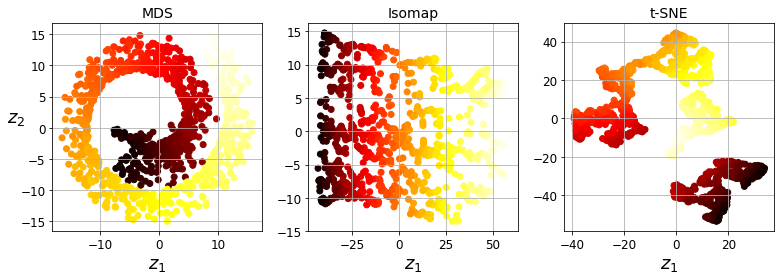

In [71]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("other_dim_reduction_plot")
plt.show()